In [1]:
import cupy as cp
import matplotlib.pyplot as plt
import pandas as pd
import time
from utils import *

%matplotlib inline

## Sizes and propagation settings

In [2]:
n = 1024  # data size in each dimension
npsi = n + n // 4  # object size in each dimension
pad = n // 16  # pad for the reconstructed probe
nq = n + 2 * pad  # probe size
ex = 8  # extra padding for shifts
npatch = nq + 2 * ex  # patch size for shifts
npos = 16  # total number of positions

voxelsize = 2e-8  # [m]
distance = 0.0043  # [m]
energy = 33.35  # [keV]
wavelength = 1.24e-09 / energy  # [m]
eps = 1e-8  # avoid division by 0 in computations

## Load object, probe, and 16 positions

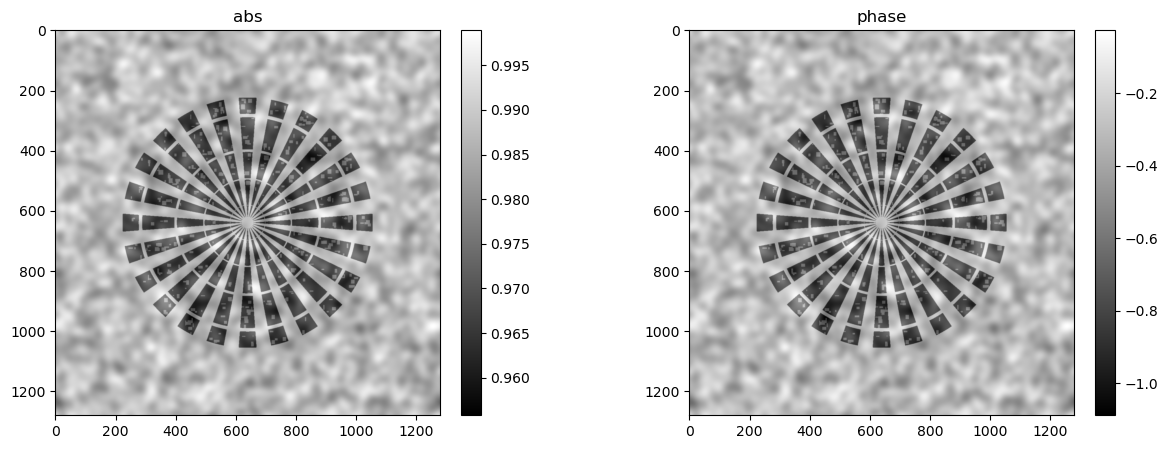

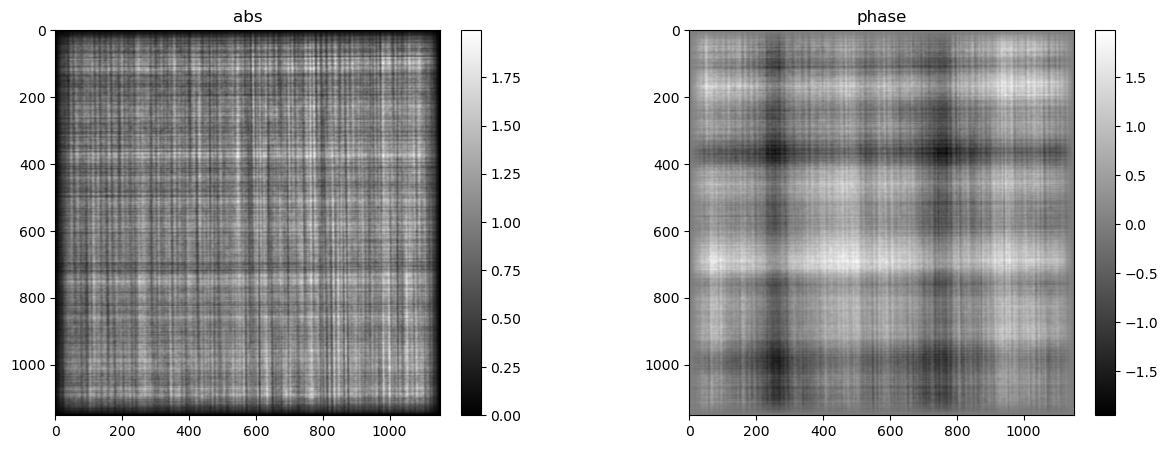

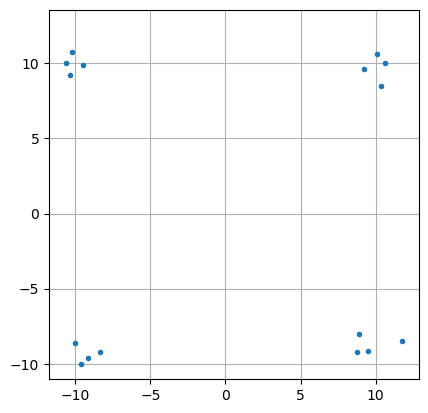

In [3]:
psi = cp.load("psi.npy")
q = cp.load("q.npy")
pos = cp.load("pos.npy")

mshow_polar(psi)
mshow_polar(q)
mplot_positions(pos)

### Introduce position error

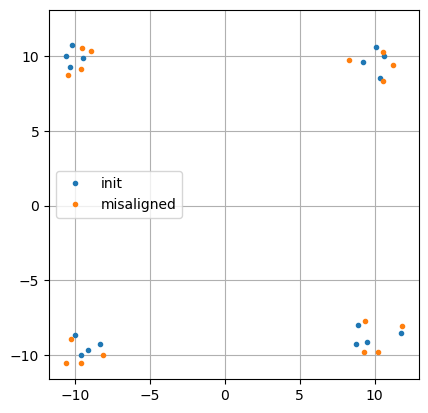

In [4]:
cp.random.seed(100)
pos_init = pos + (cp.random.random(pos.shape) - 0.5) * 2

plt.plot(pos[:, 1].get(), pos[:, 0].get(), ".", label="init")
plt.plot(pos_init[:, 1].get(), pos_init[:, 0].get(), ".", label="misaligned")

plt.legend()
plt.axis("square")
plt.grid()

## Fresnel kernel

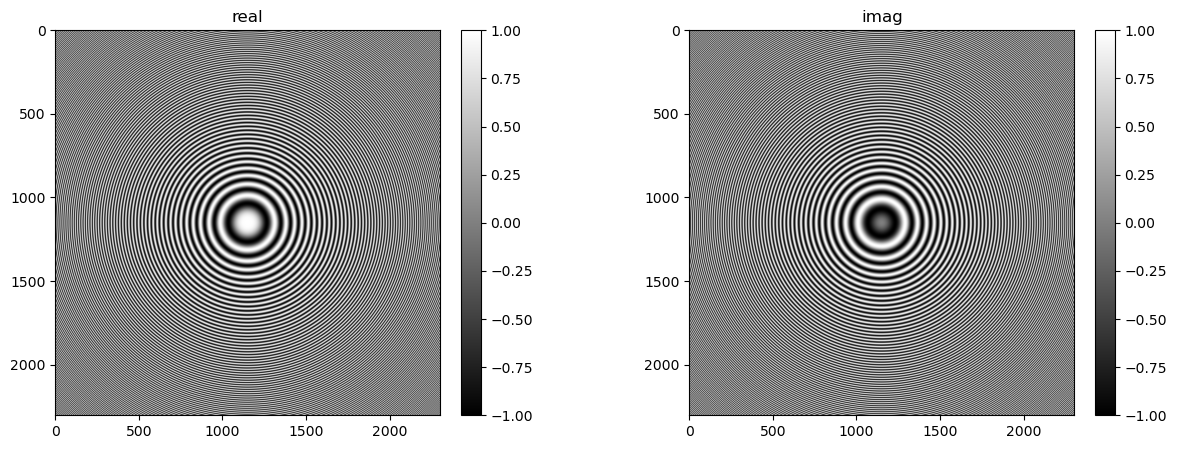

In [5]:
fx = cp.fft.fftfreq(nq * 2, d=voxelsize).astype("float32")
[fx, fy] = cp.meshgrid(fx, fx)
fker = cp.exp(-1j * cp.pi * wavelength * distance * (fx**2 + fy**2))
mshow_complex(cp.fft.fftshift(fker))

## Construct operators

In [6]:
# placing/extracting patches is better to do with CUDA C
Efast_kernel = cp.RawKernel(
    r"""                              
extern "C" 
void __global__ Efast(float2* res, float2 *psi, int* stx, int* sty, int npos, int npatch, int npsi)
{
    int tx = blockDim.x * blockIdx.x + threadIdx.x;
    int ty = blockDim.y * blockIdx.y + threadIdx.y;
    int tz = blockDim.z * blockIdx.z + threadIdx.z;

    if (tx >= npatch || ty >= npatch || tz >= npos)
        return;        
    int ind_out = tz*npatch*npatch+ty*npatch+tx;    
    int ind_in = (sty[tz]+ty)*npsi+stx[tz]+tx;                                                           
    res[ind_out] = psi[ind_in];
}
""",
    "Efast",
)

ETfast_kernel = cp.RawKernel(
    r"""                              
extern "C" 
void __global__ ETfast(float2* res, float2 *psi, int* stx, int* sty, int npos, int npatch, int npsi)
{
    int tx = blockDim.x * blockIdx.x + threadIdx.x;
    int ty = blockDim.y * blockIdx.y + threadIdx.y;
    int tz = blockDim.z * blockIdx.z + threadIdx.z;

    if (tx >= npatch || ty >= npatch || tz >= npos)
        return;        
    int ind_out = tz*npatch*npatch+ty*npatch+tx;    
    int ind_in = (sty[tz]+ty)*npsi+stx[tz]+tx;                                                           
    atomicAdd(&psi[ind_in].x,res[ind_out].x);
    atomicAdd(&psi[ind_in].y,res[ind_out].y);
}
""",
    "ETfast",
)


def E(psi, ri):
    """Extract patches"""

    ## Slow version
    # stx = npsi // 2 - ri[:, 1] - npatch // 2
    # endx = stx + npatch
    # sty = npsi // 2 - ri[:, 0] - npatch // 2
    # endy = sty + npatch
    # for k in range(len(stx)):
    #     res[k] = psi[sty[k] : endy[k], stx[k] : endx[k]]

    stx = npsi // 2 - ri[:, 1] - npatch // 2
    sty = npsi // 2 - ri[:, 0] - npatch // 2
    res = cp.empty([len(stx), npatch, npatch], dtype="complex64")
    Efast_kernel(
        (
            int(cp.ceil(npatch / 16)),
            int(cp.ceil(npatch / 16)),
            int(cp.ceil(len(stx) / 4)),
        ),
        (16, 16, 4),
        (res, psi, stx, sty, len(stx), npatch, npsi),
    )
    return res


def ET(psi, psir, ri):
    """Adjoint extract patches"""

    ## Slow version
    # stx = npsi // 2 - ri[:, 1] - npatch // 2
    # endx = stx + npatch
    # sty = npsi // 2 - ri[:, 0] - npatch // 2
    # endy = sty + npatch
    # for k in range(len(stx)):
    #     psi[sty[k] : endy[k], stx[k] : endx[k]] += psir[k]

    stx = npsi // 2 - ri[:, 1] - npatch // 2
    sty = npsi // 2 - ri[:, 0] - npatch // 2
    ETfast_kernel(
        (
            int(cp.ceil(npatch / 16)),
            int(cp.ceil(npatch / 16)),
            int(cp.ceil(len(stx) / 4)),
        ),
        (16, 16, 4),
        (psir, psi, stx, sty, len(stx), npatch, npsi),
    )
    return psi


def D(psi):
    """Forward propagator"""

    # convolution
    ff = cp.pad(psi, ((0, 0), (nq // 2, nq // 2), (nq // 2, nq // 2)))
    ff = cp.fft.ifft2(cp.fft.fft2(ff) * fker)
    ff = ff[:, nq // 2 : -nq // 2, nq // 2 : -nq // 2]

    # crop to detector size
    ff = ff[:, pad : nq - pad, pad : nq - pad]
    return ff


def DT(psi):
    """Adjoint propagator"""

    # pad to the probe size
    ff = cp.pad(psi, ((0, 0), (pad, pad), (pad, pad)))

    # convolution
    ff = cp.pad(ff, ((0, 0), (nq // 2, nq // 2), (nq // 2, nq // 2)))
    ff = cp.fft.ifft2(cp.fft.fft2(ff) / fker)
    ff = ff[:, nq // 2 : -nq // 2, nq // 2 : -nq // 2]
    return ff


def S(psi, ri, r):
    """Extract patches with subpixel shift"""
    psir = E(psi, ri)

    x = cp.fft.fftfreq(npatch).astype("float32")
    [y, x] = cp.meshgrid(x, x)
    tmp = cp.exp(
        -2 * cp.pi * 1j * (y * r[:, 1, None, None] + x * r[:, 0, None, None])
    ).astype("complex64")
    psir = cp.fft.ifft2(tmp * cp.fft.fft2(psir))
    psir = psir[:, ex : npatch - ex, ex : npatch - ex]
    return psir


def ST(d, ri, r):
    """Adjont extract patches with subpixel shift"""
    psi = cp.zeros([npsi, npsi], dtype="complex64")
    psir = cp.pad(d, ((0, 0), (ex, ex), (ex, ex)))

    x = cp.fft.fftfreq(npatch).astype("float32")
    [y, x] = cp.meshgrid(x, x)
    tmp = cp.exp(
        2 * cp.pi * 1j * (y * r[:, 1, None, None] + x * r[:, 0, None, None])
    ).astype("complex64")
    psir = cp.fft.ifft2(tmp * cp.fft.fft2(psir))

    ET(psi, psir, ri)
    return psi


# adjoint tests
rr_test = 10 * (cp.random.random([npos, 2]) - 0.5).astype("float32")
ri_test = rr_test.astype("int32")
r_test = rr_test - ri_test

arr1 = (cp.random.random([npsi, npsi]) + 1j * cp.random.random([npsi, npsi])).astype(
    "complex64"
)
arr2 = E(arr1, ri_test)
arr3 = arr1 * 0
ET(arr3, arr2, ri_test)
print("<E(psi),E(psi)>==<psi,ET(E(psi)):")
print(f"{cp.sum(arr1 * cp.conj(arr3))}==\n{cp.sum(arr2 * cp.conj(arr2))}\n")

arr1 = (cp.random.random([npsi, npsi]) + 1j * cp.random.random([npsi, npsi])).astype(
    "complex64"
)
arr2 = S(arr1, ri_test, r_test)
arr3 = ST(arr2, ri_test, r_test)
print("<S(psi),S(psi)>==<psi,ST(S(psi)):")
print(f"{cp.sum(arr1 * cp.conj(arr3))}==\n{cp.sum(arr2 * cp.conj(arr2))}\n")

arr1 = (
    cp.random.random([npos, nq, nq]) + 1j * cp.random.random([npos, nq, nq])
).astype("complex64")
arr2 = D(arr1)
arr3 = DT(arr2)
print("<D(psi),D(psi)>==<psi,DT(D(psi)):")
print(f"{cp.sum(arr1 * cp.conj(arr3))}==\n{cp.sum(arr2 * cp.conj(arr2))}\n")

<E(psi),E(psi)>==<psi,ET(E(psi)):
(14552014-0.0012468652566894889j)==
(14552014-0.00023198436247184873j)

<S(psi),S(psi)>==<psi,ST(S(psi)):
(14156260-0.055416107177734375j)==
(14156261-4.6842014853609726e-05j)

<D(psi),D(psi)>==<psi,DT(D(psi)):
(10950147+0.11944580078125j)==
(10950147-4.5918990508653224e-05j)



### Model data for the object, and a reference image when the object is out
### $d = |D(qS_{r_i+r}(\psi))|^2$, where $r_i$ is integer part of the position and $r$ is floating part
### $d_{\text{ref}} = |D(q)|^2$

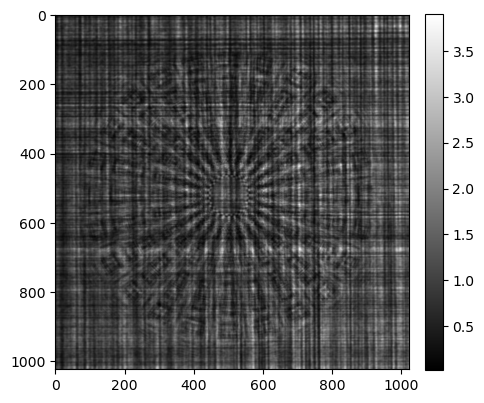

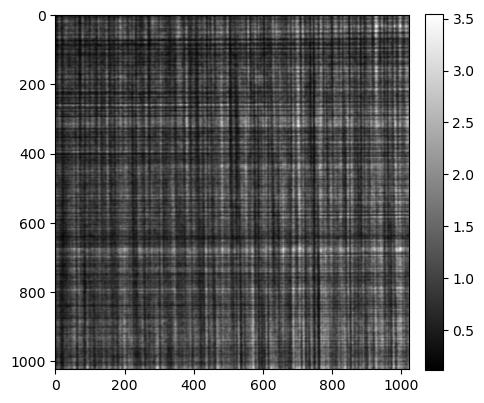

In [7]:
ri = cp.floor(pos).astype("int32")
r = pos - ri
data = cp.abs(D(q * S(psi, ri, r))) ** 2

dref = cp.abs(D(q * (1 + 0 * S(psi, ri, r)))) ** 2
dref = dref[0]

mshow(data[0])
mshow(dref)

### Initial guess for the object calculated with the Paganin method

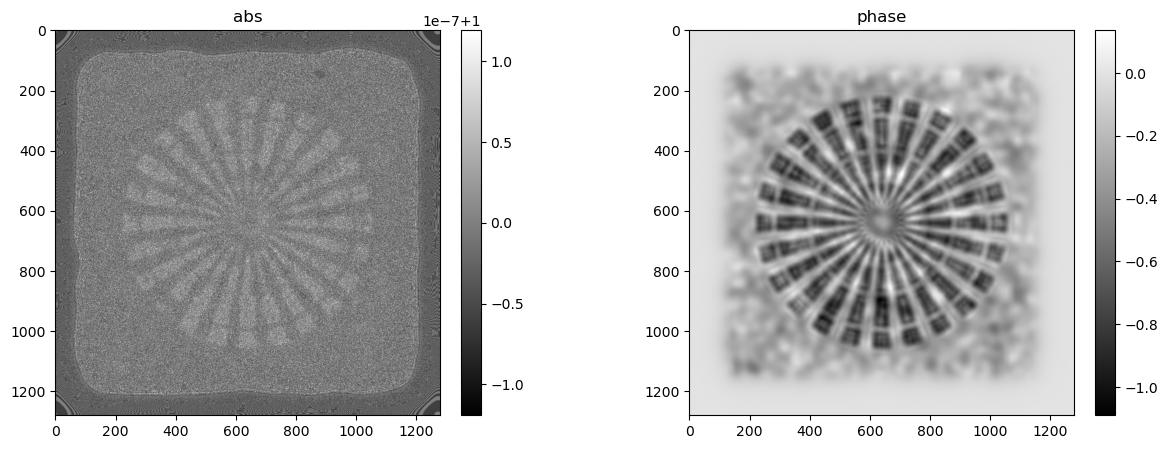

In [8]:
def Paganin(data, wavelength, voxelsize, delta_beta, alpha):
    fx = cp.fft.fftfreq(data.shape[-1], d=voxelsize).astype("float32")
    [fx, fy] = cp.meshgrid(fx, fx)
    rad_freq = cp.fft.fft2(data)
    taylorExp = 1 + wavelength * distance * cp.pi * (delta_beta) * (fx**2 + fy**2)
    numerator = taylorExp * (rad_freq)
    denominator = taylorExp**2 + alpha
    phase = cp.log(cp.real(cp.fft.ifft2(numerator / denominator)))
    phase = delta_beta * 0.5 * phase
    return phase


def rec_init(rdata, ri):
    recMultiPaganin = cp.zeros([npsi, npsi], dtype="float32")
    recMultiPaganinr = cp.zeros(
        [npsi, npsi], dtype="float32"
    )  # to compensate for overlap
    for j in range(npos):
        r = rdata[j]
        pos = r * 0 + 1  # to compensate for overlap
        rpsi = cp.ones([npsi, npsi], dtype="float32")
        rrpsi = cp.ones([npsi, npsi], dtype="float32")
        stx = npsi // 2 - ri[j, 1] - n // 2
        endx = stx + n
        sty = npsi // 2 - ri[j, 0] - n // 2
        endy = sty + n
        rpsi[sty:endy, stx:endx] = r
        rrpsi[sty:endy, stx:endx] = pos
        rpsi = Paganin(rpsi, wavelength, voxelsize, 24.05, 1e-6)
        recMultiPaganin += rpsi
        recMultiPaganinr += rrpsi

    recMultiPaganinr[cp.abs(recMultiPaganinr) < 5e-2] = 1
    recMultiPaganin /= recMultiPaganinr
    recMultiPaganin = cp.exp(1j * recMultiPaganin)
    return recMultiPaganin


ri = cp.round(pos_init).astype("int32")
rdata = data / (dref + 1e-9)
psi_init = rec_init(rdata, ri)
mshow_polar(psi_init)

#### Initial guess for the probe calculated by backpropagating the square root of the reference image
#### Smooth the probe borders for stability

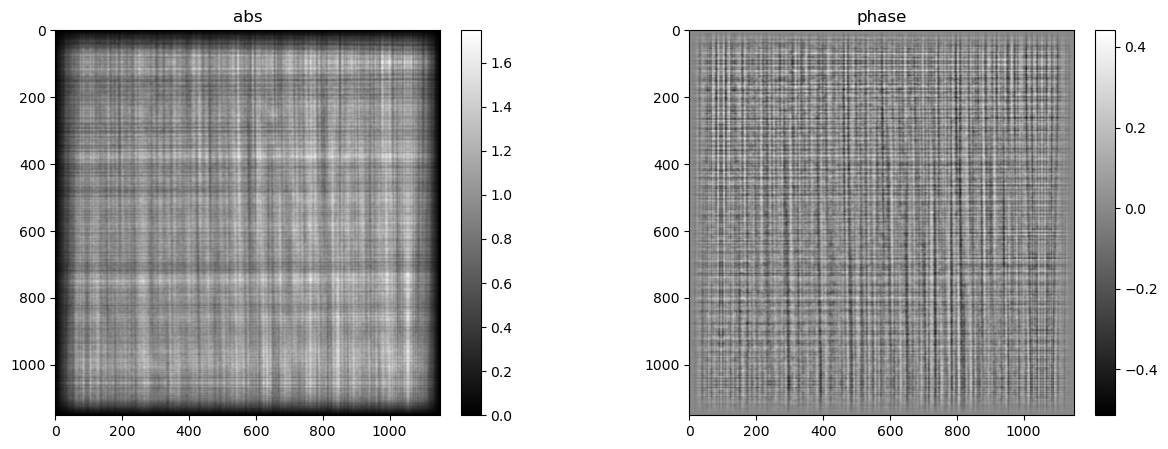

In [9]:
q_init = DT(cp.sqrt(dref[cp.newaxis]))[0]

ppad = 3 * pad // 2
q_init = cp.pad(
    q_init[ppad : nq - ppad, ppad : nq - ppad],
    ((ppad, ppad), (ppad, ppad)),
    "symmetric",
)
v = cp.ones(nq, dtype="float32")
vv = cp.sin(cp.linspace(0, cp.pi / 2, ppad))
v[:ppad] = vv
v[nq - ppad :] = vv[::-1]
v = cp.outer(v, v)
q_init = cp.abs(q_init * v) * cp.exp(1j * cp.angle(q_init) * v)

mshow_polar(q_init)

# Reconstruction by the bilinear Hessian (BH) method

### Minimization functional for the Gaussian model 
### $F(\Psi)=\||\Psi|-d\|_2^2$, where $\Psi = D(qS_{r_i+r}(\psi))$
### $f(q,\psi,r) = \||D(qS_{r_i+r}(\psi))|-d\|_2^2$

### Position variable is split into the integer and float parts: ri+r. 
### ri is fixed and used for extracting patches, optimization is done for r  

In [10]:
def minF(big_psi, d):
    return cp.linalg.norm(cp.abs(big_psi) - d) ** 2

### Reused variables to accelerate computations $S_{r_i+r}\psi$ and $\Psi=D(qS_{r_i+r}(\psi))$

In [11]:
def calc_reused(reused, vars):
    """Calculate variables reused during calculations"""
    (q, psi, ri, r) = (vars["q"], vars["psi"], vars["ri"], vars["r"])

    spsi = S(psi, ri, r)

    reused["spsi"] = spsi
    reused["big_psi"] = D(spsi * q)

### Gradient for the Gaussian noise model

##### $$\nabla F|_{\Psi_0}=2\cdot\left( \Psi_0-d\cdot\Psi_0/|\Psi_0|\right)$$
##### $$\Phi_0=D^*(\nabla F|_{\Psi_0})$$

### store it with reused variables

In [12]:
def calc_phi(reused, d):
    big_psi = reused["big_psi"]
    td = d * (big_psi / (cp.abs(big_psi) + eps))
    reused["big_phi"] = DT(2 * (big_psi - td))

### Gradients for the object, probe and positions

##### $$\nabla_{\psi} f|_{(q_0,\psi_0,\boldsymbol{r}_0)}= S_{r_i+r_{0}}^*\left(\overline{J(q_0)}\cdot \Phi_0\right)$$

##### $$\nabla_{q} f|_{(q_0,\psi_0,\boldsymbol{r}_0)}=J^*\left( \overline{S_{r_i+r_0}(\psi_0)}\cdot \Phi_0\right).$$
##### $$\nabla_{\boldsymbol{r}_0} f|_{(q_0,\psi_0,\boldsymbol{r}_0)}=\textsf{Re}\Big(\big( \Big\langle \overline{q_0}\cdot \Phi_0,   C(\mathcal{F}^{-1}(-2\pi i \xi_1 e^{ -2\pi i \boldsymbol{r}_{0,k}\cdot \boldsymbol{\xi}}\hat{\psi_0}))\Big\rangle,\Big\langle \overline{q_0}\cdot \Phi_0,C(\mathcal{F}^{-1}(-2\pi i \xi_2 e^{ -2\pi i \boldsymbol{r}_{0,k}\cdot \boldsymbol{\xi}}\hat{\psi_0})) \Big\rangle\big)\Big)_{k=1}^K. $$




In [13]:
def gradient_psi(q, ri, r, big_phi):
    return ST(cp.conj(q) * big_phi, ri, r)


def gradient_q(spsi, big_phi):
    return cp.sum(cp.conj(spsi) * big_phi, axis=0)


def gradient_r(psi, q, ri, r, big_phi):
    # frequencies
    xi1 = cp.fft.fftfreq(npatch).astype("float32")
    xi2, xi1 = cp.meshgrid(xi1, xi1)

    # multipliers in frequencies
    w = cp.exp(
        -2 * cp.pi * 1j * (xi2 * r[:, 1, None, None] + xi1 * r[:, 0, None, None])
    )

    # Gradient parts
    tmp = E(psi, ri)
    tmp = cp.fft.fft2(tmp)

    dt1 = cp.fft.ifft2(w * xi1 * tmp)
    dt2 = cp.fft.ifft2(w * xi2 * tmp)
    dt1 = -2 * cp.pi * 1j * dt1[:, ex : nq + ex, ex : nq + ex]
    dt2 = -2 * cp.pi * 1j * dt2[:, ex : nq + ex, ex : nq + ex]

    # inner product with big_phi
    gradr = cp.zeros([npos, 2], dtype="float32")
    gradr[:, 0] = redot(big_phi, q * dt1, axis=(1, 2))
    gradr[:, 1] = redot(big_phi, q * dt2, axis=(1, 2))
    return gradr


def gradients(vars, pars, reused):
    (q, psi, ri, r) = (vars["q"], vars["psi"], vars["ri"], vars["r"])
    (big_phi, spsi) = (reused["big_phi"], reused["spsi"])

    dpsi = gradient_psi(q, ri, r, big_phi)
    dprb = gradient_q(spsi, big_phi)
    dr = gradient_r(psi, q, ri, r, big_phi)
    grads = {"psi": dpsi, "q": dprb, "r": dr}
    return grads

## Bilinear hessian 
##### $$\frac{1}{2}\mathcal{H}|_{\Psi_0}(\Delta\Psi^{(1)},\Delta\Psi^{(2)})= \left\langle \mathbf{1}-d_{0}, \mathsf{Re}({\Delta\Psi^{(1)}}\overline{\Delta\Psi^{(2)}})\right\rangle+\left\langle d_{0},(\mathsf{Re} (\overline{l_0}\cdot \Delta\Psi^{(1)}))\cdot (\mathsf{Re} (\overline{l_0}\cdot \Delta\Psi^{(2)})) \right\rangle$$
##### $$l_0=\Psi_0/|\Psi_0|$$
##### $$d_0=d/|\Psi_0|$$
## to adjust for the paper..

In [14]:
def hessian_F(big_psi, dbig_psi1, dbig_psi2, d):
    l0 = big_psi / (cp.abs(big_psi) + eps)
    d0 = d / (cp.abs(big_psi) + eps)
    v1 = cp.sum((1 - d0) * reprod(dbig_psi1, dbig_psi2))
    v2 = cp.sum(d0 * reprod(l0, dbig_psi1) * reprod(l0, dbig_psi2))
    return 2 * (v1 + v2)

#### Updates with scaling
$$ \eta^{(j)}_z=-\rho_z^2\nabla_z f|_{({x}^{(j)},{{y}}^{(j)})}+\beta_j \eta^{(j)}_{{{z}}}.$$
$$\beta_j = \frac{\mathcal{H}^{ f}|_{({x}^{(j)},{{y}}^{(j)})}\Big((\nabla_{{{{x}}}} \rho_x^2 f|_{({x}^{(j)},{{y}}^{(j)})},\rho_y^2\nabla_{{{{y}}}} f|_{({x}^{(j)},{{y}}^{(j)})}), ( \eta^{(j-1)}_{{{x}}},\eta^{(j-1)}_{{{y}}})\Big)}{\mathcal{H}^{ f}|_{({x}^{(j)},{{y}}^{(j)})}\Big((\eta^{(j-1)}_{{{x}}}, \eta^{(j-1)}_{{{y}}}),(\eta^{(j-1)}_{{{x}}}, \eta^{(j-1)}_{{{y}}})\Big)}$$

\begin{equation}
    \alpha^{(j)}=\frac{\Big\langle(\nabla_{{{{x}}}} f|_{({x}^{(j)},{{y}}^{(j)})},\nabla_{{{{y}}}} f|_{({x}^{(j)},{{y}}^{(j)})}), ( \eta^{(j)}_{{{x}}}, \eta^{(j)}_{{{y}}})\Big\rangle}{\mathcal{H}^{ f}|_{({x}^{(j)},{{y}}^{(j)})}\Big(( \eta^{(j)}_{{{x}}}, \eta^{(j)}_{{{y}}}),( \eta^{(j)}_{{{x}}}, \eta^{(j)}_{{{y}}})\Big)}.
\end{equation} 

In [15]:
def calc_beta(vars, grads, etas, pars, reused, d):
    (q, psi, ri, r) = (vars["q"], vars["psi"], vars["ri"], vars["r"])
    (spsi, big_psi, big_phi) = (reused["spsi"], reused["big_psi"], reused["big_phi"])
    (dpsi2, dq2, dr2) = (etas["psi"], etas["q"], etas["r"])

    # note scaling with rho
    rho = pars["rho"]
    (dpsi1, dq1, dr1) = (
        grads["psi"] * rho[0] ** 2,
        grads["q"] * rho[1] ** 2,
        grads["r"] * rho[2] ** 2,
    )

    # frequencies
    xi1 = cp.fft.fftfreq(npatch).astype("float32")
    [xi2, xi1] = cp.meshgrid(xi1, xi1)

    # multipliers in frequencies
    dr1 = dr1[:, :, cp.newaxis, cp.newaxis]
    dr2 = dr2[:, :, cp.newaxis, cp.newaxis]
    w = cp.exp(
        -2 * cp.pi * 1j * (xi2 * r[:, 1, None, None] + xi1 * r[:, 0, None, None])
    )
    w1 = xi1 * dr1[:, 0] + xi2 * dr1[:, 1]
    w2 = xi1 * dr2[:, 0] + xi2 * dr2[:, 1]
    w12 = (
        xi1**2 * dr1[:, 0] * dr2[:, 0]
        + xi1 * xi2 * (dr1[:, 0] * dr2[:, 1] + dr1[:, 1] * dr2[:, 0])
        + xi2**2 * dr1[:, 1] * dr2[:, 1]
    )
    w22 = (
        xi1**2 * dr2[:, 0] ** 2
        + 2 * xi1 * xi2 * (dr2[:, 0] * dr2[:, 1])
        + xi2**2 * dr2[:, 1] ** 2
    )

    # DT, D2T terms
    tmp1 = E(dpsi1, ri)
    tmp1 = cp.fft.fft2(tmp1)
    sdpsi1 = cp.fft.ifft2(w * tmp1)[:, ex : nq + ex, ex : nq + ex]
    dt12 = -2 * cp.pi * 1j * cp.fft.ifft2(w * w2 * tmp1)[:, ex : nq + ex, ex : nq + ex]

    tmp2 = E(dpsi2, ri)
    tmp2 = cp.fft.fft2(tmp2)
    sdpsi2 = cp.fft.ifft2(w * tmp2)[:, ex : nq + ex, ex : nq + ex]
    dt21 = -2 * cp.pi * 1j * cp.fft.ifft2(w * w1 * tmp2)[:, ex : nq + ex, ex : nq + ex]
    dt22 = -2 * cp.pi * 1j * cp.fft.ifft2(w * w2 * tmp2)[:, ex : nq + ex, ex : nq + ex]

    tmp = E(psi, ri)
    tmp = cp.fft.fft2(tmp)
    dt1 = -2 * cp.pi * 1j * cp.fft.ifft2(w * w1 * tmp)[:, ex : nq + ex, ex : nq + ex]
    dt2 = -2 * cp.pi * 1j * cp.fft.ifft2(w * w2 * tmp)[:, ex : nq + ex, ex : nq + ex]
    d2t1 = -4 * cp.pi**2 * cp.fft.ifft2(w * w12 * tmp)[:, ex : nq + ex, ex : nq + ex]
    d2t2 = -4 * cp.pi**2 * cp.fft.ifft2(w * w22 * tmp)[:, ex : nq + ex, ex : nq + ex]

    # DM,D2M terms
    d2m1 = q * dt12 + q * dt21 + q * d2t1
    d2m1 += dq1 * sdpsi2 + dq2 * sdpsi1
    d2m1 += dq1 * dt2 + dq2 * dt1

    d2m2 = q * dt22 + q * dt22 + q * d2t2
    d2m2 += dq2 * sdpsi2 + dq2 * sdpsi2
    d2m2 += dq2 * dt2 + dq2 * dt2

    dm1 = dq1 * spsi + q * (sdpsi1 + dt1)
    dm2 = dq2 * spsi + q * (sdpsi2 + dt2)

    # top and bottom parts
    Ddm1 = D(dm1)
    Ddm2 = D(dm2)

    top = redot(big_phi, d2m1) + hessian_F(big_psi, Ddm1, Ddm2, d)
    bottom = redot(big_phi, d2m2) + hessian_F(big_psi, Ddm2, Ddm2, d)

    return top / bottom


def calc_alpha(vars, grads, etas, pars, reused, d):
    (q, psi, ri, r) = (vars["q"], vars["psi"], vars["ri"], vars["r"])
    (dpsi1, dq1, dr1) = (grads["psi"], grads["q"], grads["r"])
    (dpsi2, dq2, dr2) = (etas["psi"], etas["q"], etas["r"])
    (spsi, big_psi, big_phi) = (reused["spsi"], reused["big_psi"], reused["big_phi"])

    # top part
    top = -redot(dpsi1, dpsi2) - redot(dq1, dq2) - redot(dr1, dr2)

    # frequencies
    xi1 = cp.fft.fftfreq(npatch).astype("float32")
    [xi2, xi1] = cp.meshgrid(xi1, xi1)

    # multipliers in frequencies
    dr = dr2[:, :, cp.newaxis, cp.newaxis]
    w = cp.exp(
        -2 * cp.pi * 1j * (xi2 * r[:, 1, None, None] + xi1 * r[:, 0, None, None])
    )
    w1 = xi1 * dr[:, 0] + xi2 * dr[:, 1]
    w2 = (
        xi1**2 * dr[:, 0] ** 2
        + 2 * xi1 * xi2 * (dr[:, 0] * dr[:, 1])
        + xi2**2 * dr[:, 1] ** 2
    )

    # DT,D2T terms, and spsi
    tmp = E(dpsi2, ri)
    tmp = cp.fft.fft2(tmp)
    sdpsi = cp.fft.ifft2(w * tmp)[:, ex : nq + ex, ex : nq + ex]
    dt2 = -2 * cp.pi * 1j * cp.fft.ifft2(w * w1 * tmp)[:, ex : nq + ex, ex : nq + ex]

    tmp = E(psi, ri)
    tmp = cp.fft.fft2(tmp)
    dt = -2 * cp.pi * 1j * cp.fft.ifft2(w * w1 * tmp)[:, ex : nq + ex, ex : nq + ex]
    d2t = -4 * cp.pi**2 * cp.fft.ifft2(w * w2 * tmp)[:, ex : nq + ex, ex : nq + ex]

    # DM and D2M terms
    d2m2 = q * (2 * dt2 + d2t) + 2 * dq2 * sdpsi + 2 * dq2 * dt
    dm = dq2 * spsi + q * (sdpsi + dt)

    # bottom part
    Ddm = D(dm)
    bottom = redot(big_phi, d2m2) + hessian_F(big_psi, Ddm, Ddm, d)

    return top / bottom, top, bottom

In [16]:
def plot_debug(vars, etas, pars, top, bottom, alpha, data, i):
    """Check the minimization functional behaviour"""
    if i % pars["vis_step"] == 0 and pars["vis_step"] != -1:
        (q, psi, ri, r) = (vars["q"], vars["psi"], vars["ri"], vars["r"])
        (dq2, dpsi2, dr2) = (etas["q"], etas["psi"], etas["r"])
        
        npp = 13
        errt = cp.zeros(npp * 2)
        errt2 = cp.zeros(npp * 2)
        for k in range(0, npp * 2):
            psit = psi + (alpha * k / (npp - 1)) * dpsi2
            qt = q + (alpha * k / (npp - 1)) * dq2
            rt = r + (alpha * k / (npp - 1)) * dr2

            errt[k] = minF(D(S(psit, ri, rt) * qt), data)

        t = alpha * (cp.arange(2 * npp)) / (npp - 1)
        errt2 = minF(D(S(psi, ri, r) * q), data)
        errt2 = errt2 - top * t + 0.5 * bottom * t**2

        plt.plot(
            alpha.get() * cp.arange(2 * npp).get() / (npp - 1),
            errt.get(),
            ".",
            label="approximation",
        )
        plt.plot(
            alpha.get() * cp.arange(2 * npp).get() / (npp - 1),
            errt2.get(),
            ".",
            label="real",
        )
        plt.legend()
        plt.grid()
        plt.show()


def vis_debug(vars, pars, i):
    """Visualization and data saving"""
    if i % pars["vis_step"] == 0 and pars["vis_step"] != -1:
        (q, psi) = (vars["q"], vars["psi"])
        mshow_polar(psi)
        mshow_polar(q)


def error_debug(vars, pars, reused, data, i):
    """Visualization and data saving"""
    if i % pars["err_step"] == 0 and pars["err_step"] != -1:
        err = minF(reused["big_psi"], data)
        print(f"{i}) {err=:1.5e}", flush=True)
        vars["table"].loc[len(vars["table"])] = [i, err.get(), time.time()]
        # vars["table"].to_csv(f"{pars['flg']}", index=False)

0) err=1.36920e+05
1) err=3.18217e+04
2) err=1.44001e+04
3) err=7.74366e+03
4) err=5.88834e+03
5) err=3.95139e+03
6) err=3.03220e+03
7) err=2.52665e+03
8) err=2.25084e+03
9) err=2.07280e+03
10) err=1.86846e+03
11) err=1.67665e+03
12) err=1.50052e+03
13) err=1.33526e+03
14) err=1.21028e+03
15) err=1.12155e+03
16) err=1.03116e+03
17) err=9.46798e+02
18) err=8.76186e+02
19) err=8.09101e+02
20) err=7.57118e+02
21) err=7.01411e+02
22) err=6.57182e+02
23) err=6.15896e+02
24) err=5.80151e+02
25) err=5.45769e+02
26) err=5.17649e+02
27) err=4.87754e+02
28) err=4.62253e+02
29) err=4.38158e+02
30) err=4.16868e+02
31) err=3.98783e+02
32) err=3.79079e+02
33) err=3.62588e+02
34) err=3.45866e+02
35) err=3.31410e+02
36) err=3.17460e+02
37) err=3.05586e+02
38) err=2.92648e+02
39) err=2.82015e+02
40) err=2.70114e+02
41) err=2.61088e+02
42) err=2.51306e+02
43) err=2.43043e+02
44) err=2.34429e+02
45) err=2.26692e+02
46) err=2.19095e+02
47) err=2.12221e+02
48) err=2.05715e+02
49) err=1.99334e+02
50) err=1.

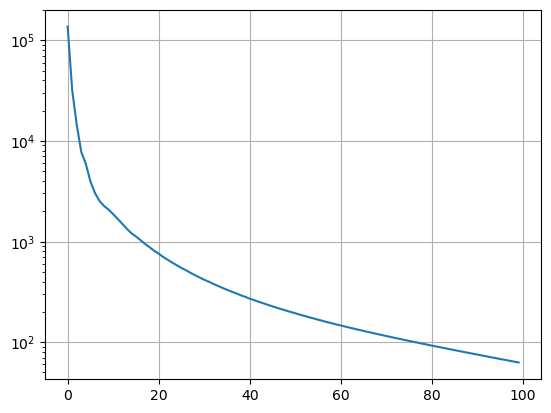

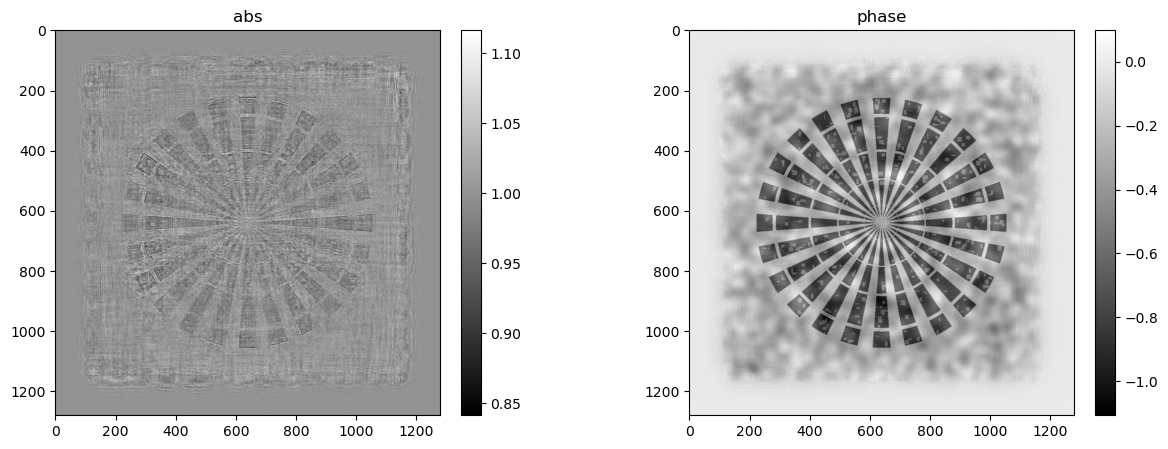

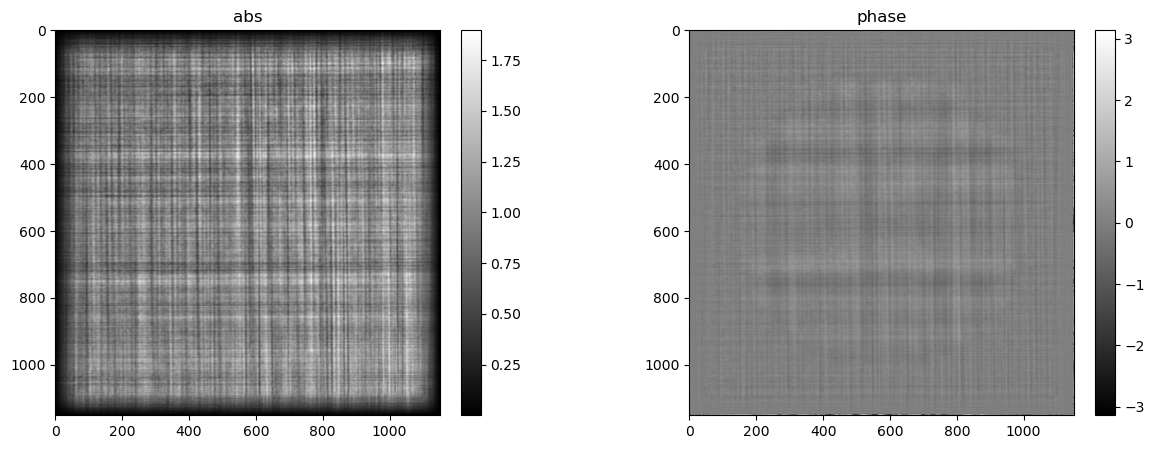

[]

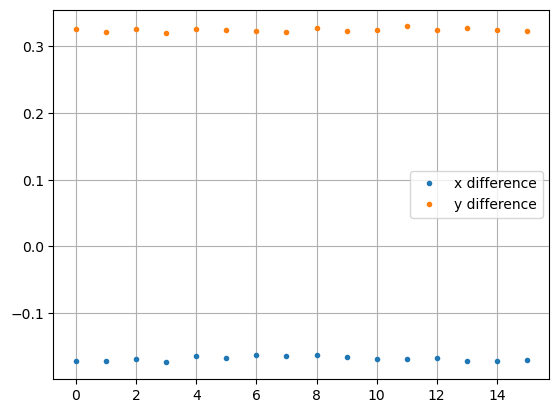

In [17]:
def BH(data, vars, pars):
    data = cp.sqrt(data)

    alpha = 1
    rho = pars["rho"]
    reused = {}

    for i in range(pars["niter"]):
        # Calc reused variables and big_phi
        calc_reused(reused, vars)
        calc_phi(reused, data)

        # debug and visualization
        error_debug(vars, pars, reused, data, i)
        vis_debug(vars, pars, i)

        # gradients for each variable
        grads = gradients(vars, pars, reused)

        if i == 0 or pars["method"] == "BH-GD":
            etas = {}
            etas["psi"] = -grads["psi"] * rho[0] ** 2
            etas["q"] = -grads["q"] * rho[1] ** 2
            etas["r"] = -grads["r"] * rho[2] ** 2
        else:
            # conjugate direction
            beta = calc_beta(vars, grads, etas, pars, reused, data)
            etas["psi"] = -grads["psi"] * rho[0] ** 2 + beta * etas["psi"]
            etas["q"] = -grads["q"] * rho[1] ** 2 + beta * etas["q"]
            etas["r"] = -grads["r"] * rho[2] ** 2 + beta * etas["r"]

        # step length
        alpha, top, bottom = calc_alpha(vars, grads, etas, pars, reused, data)

        # debug approxmation
        plot_debug(vars, etas, pars, top, bottom, alpha, data, i)

        vars["psi"] += alpha * etas["psi"]
        vars["q"] += alpha * etas["q"]
        vars["r"] += alpha * etas["r"]

    return vars


# parameters
pars = {"niter": 100, "err_step": 1, "vis_step": -1}
pars["rho"] = [1, 2, 0.1]
pars["method"] = "BH-CG"
pars["flg"] = f"{pars['method']}_{pars['rho'][0]}_{pars['rho'][1]}_{pars['rho'][2]}"

# variables
vars = {}
vars["psi"] = psi_init.copy()
vars["q"] = q_init.copy()
vars["ri"] = cp.floor(pos_init).astype("int32")
vars["r"] = cp.array(pos_init - cp.floor(pos_init).astype("int32")).astype("float32")
vars["table"] = pd.DataFrame(columns=["iter", "err", "time"])

# reconstruction
vars = BH(data, vars, pars)

# results
erra = vars["table"]["err"].values
plt.plot(erra, label=f"{pars['flg']}")
plt.yscale("log")
plt.grid()
mshow_polar(vars["psi"])
mshow_polar(vars["q"])
pos_rec = vars["ri"] + vars["r"]
plt.plot((pos[:, 1] - pos_rec[:, 1]).get(), ".", label="x difference")
plt.plot((pos[:, 0] - pos_rec[:, 0]).get(), ".", label="y difference")
plt.legend()
plt.grid()
plt.plot()